# pRF fitting using a Keras CNN

this notebook implements pRF fitting using a CNN defined in keras. 

In [43]:
%load_ext autoreload
%autoreload 2

import os, json
import nibabel as nb

from keras import metrics 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LocallyConnected1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.utils.vis_utils import plot_model

import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
%matplotlib inline

base_dir = '/home/knapen/projects/prf_lyon/'
os.chdir(base_dir)

os.chdir(os.path.join(base_dir, 'analysis'))
from prf_fit import *

with open(os.path.join(base_dir, 'analysis', 'settings.json')) as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First, we have to load some data to prepare things.
Most of this is taken from an earlier notebook that implements the grid search stage of pRF fitting, much of it is likely to be redundant. It creates a prf fit object that can load or create grid search regressors. For now, we're only using its functionality to load a design matrix.

Read on for the good stuff.

In [2]:
sub = 'sub-01'

input_file = os.path.join(base_dir, 'data', sub, 'func', \
    sub+'_task-prf_acq-median_T1w_desc-preproc_bold.nii.gz')
dm_file = os.path.join(base_dir, 'data', sub, 'dm_out.npy')
    
mask_file = nb.load(os.path.join(base_dir, 'data', sub, 'func', \
     sub+'_task-prf_dir-AP_run-1_space-T1w_desc-brain_mask.nii.gz'))
mask = mask_file.get_data().astype(bool)

# for registration into pycortex
example_epi_file = os.path.join(base_dir, 'data', sub, 'func', \
     sub+'_task-prf_dir-AP_run-1_space-T1w_boldref.nii.gz')
T1_file = os.path.join(base_dir, 'data', sub, 'anat', \
     sub+'_desc-preproc_T1w.nii.gz')
fs_T1_file = os.path.join(base_dir, 'data', sub, 'anat', \
     'T1.nii.gz')

#design matrix
visual_dm = np.load(dm_file).T

# data
in_file_nii = nb.load(input_file)
data = in_file_nii.get_data().reshape((-1,in_file_nii.shape[-1]))

In [3]:
fit_model = analysis_info["fit_model"]
N_PROCS = 8

# Fit: define search grids
x_grid_bound = (-analysis_info["max_eccen"], analysis_info["max_eccen"])
y_grid_bound = (-analysis_info["max_eccen"], analysis_info["max_eccen"])
sigma_grid_bound = (analysis_info["min_size"], analysis_info["max_size"])
n_grid_bound = (analysis_info["min_n"], analysis_info["max_n"])
grid_steps = analysis_info["grid_steps"]

# Fit: define search bounds
x_fit_bound = (-analysis_info["max_eccen"]*2, analysis_info["max_eccen"]*2)
y_fit_bound = (-analysis_info["max_eccen"]*2, analysis_info["max_eccen"]*2)
sigma_fit_bound = (1e-6, 1e2)
n_fit_bound = (1e-6, 2)
beta_fit_bound = (-1e6, 1e6)
baseline_fit_bound = (-1e6, 1e6)

if fit_model == 'gauss' or fit_model == 'gauss_sg':
    bound_grids  = (x_grid_bound, y_grid_bound, sigma_grid_bound)
    bound_fits = (x_fit_bound, y_fit_bound, sigma_fit_bound, beta_fit_bound, baseline_fit_bound)
elif fit_model == 'css' or fit_model == 'css_sg':
    bound_grids  = (x_grid_bound, y_grid_bound, sigma_grid_bound, n_grid_bound)
    bound_fits = (x_fit_bound, y_fit_bound, sigma_fit_bound, n_fit_bound, beta_fit_bound, baseline_fit_bound)

# intitialize prf analysis
prf = PRF_fit(  data = data[mask.ravel()],
                fit_model = fit_model, 
                visual_design = visual_dm, 
                screen_distance = analysis_info["screen_distance"],
                screen_width = analysis_info["screen_width"],
                scale_factor = 1/2.0, 
                tr =  analysis_info["TR"],
                bound_grids = bound_grids,
                grid_steps = grid_steps,
                bound_fits = bound_fits,
                n_jobs = N_PROCS,
                sg_filter_window_length = analysis_info["sg_filt_window_length"],
                sg_filter_polyorder = analysis_info["sg_filt_polyorder"],
                sg_filter_deriv = analysis_info["sg_filt_deriv"], 
                )
# will need to move/delete this file for new predictions
prediction_file = os.path.join(base_dir, 'data', 'sub-01', 'predictions.npy')
if os.path.isfile(prediction_file):
    prf.load_grid_predictions(prediction_file=prediction_file)
else:
    prf.make_predictions(out_file=prediction_file)

## Construct training set.
From the grid search stage, we have a set of N (8000, in some version) regressors that span the grid for initial search. We also need to add intercept and slope parameters, so we add random intercepts and slopes (betas), multiplying the amount of training regressors. Also, because the network should be trained on far more than this, we create an even larger training set by "blowing up" this initial set of grid regressors. What we do, is just add noise.

In [15]:
blow_up = 50
# make extra predictions, with added noise
blow_up_noisy_predictions = np.repeat(prf.predictions, blow_up, axis=1)
# scale predictions randomly
betas = np.random.rand(blow_up_noisy_predictions.shape[1])+0.25
blow_up_noisy_predictions *= betas
# random offsets
offsets = np.random.randn(blow_up_noisy_predictions.shape[1])
blow_up_noisy_predictions += offsets

blow_up_noisy_predictions += np.random.randn(prf.predictions.shape[0], prf.predictions.shape[1] * blow_up)/5.0

extra_parameters = np.array([betas, offsets])

n_prf_parameters = 5
parameters = np.array([prf.prf_xs, prf.prf_ys, prf.prf_sigma]).reshape((3,-1))

blow_up_parameters = np.vstack((np.repeat(parameters, blow_up, axis=1), extra_parameters))

## Model setup and training
Now, we're ready to specify the model architecture. This is a simple 1D model with a very limited nr of layers. It should take the data timecourse and predict the 5 regressors. So, it starts with a convolutional set of layers `Conv1D`, and ends with a set of `Dense` layers that are linear (not softmaxed or anything). In the middle I have put a set of `LocallyConnected1D` - otherwise the network is just very poor :). The metrics and loss are specified also in line with this regression nature of the problem.

This architecture is not at all optimized for what it's supposed to do, but the first try already worked. We should discuss the possible architectural options in future meetings. 

In [40]:
# build model
model = Sequential()

model.add(Conv1D(filters=prf.n_timepoints//2, kernel_size=4, input_shape=(prf.n_timepoints,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=prf.n_timepoints//4, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LocallyConnected1D(filters=prf.n_timepoints//8, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LocallyConnected1D(filters=prf.n_timepoints//16, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
# model.add(Conv1D(filters=prf.n_timepoints//32, kernel_size=16, activation='relu'))
# model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(n_prf_parameters*2, kernel_initializer='uniform'))
model.add(Dense(n_prf_parameters))

print(model.summary())
plot_model(model, show_shapes=True, to_file='keras_1.pdf')

model.compile(loss='mse',
              optimizer='nadam',
              metrics=['mae'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 164, 83)           415       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 82, 83)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 79, 41)            13653     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 39, 41)            0         
_________________________________________________________________
locally_connected1d_10 (Loca (None, 32, 20)            210560    
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 16, 20)            0         
_________________________________________________________________
locally_connected1d_11 (Loca (None, 9, 10)             14490     
__________

### Training 
Next, we fit (train) the model. With the GPU in aeneas, this epoch and batch size is faster than anything else I've used, but this can still be optimized.

In [41]:
%%time
history = model.fit(blow_up_noisy_predictions.T[:,:,np.newaxis], blow_up_parameters.T, 
                      epochs=150, 
                      batch_size=2048, 
                      verbose=-1,
                      validation_split=0.2)


# serialize model to YAML
model_yaml = model.to_yaml()
with open(os.path.join(base_dir, 'data', 'model.yaml'), "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(os.path.join(base_dir, 'data', 'model.h5'))

Train on 320000 samples, validate on 80000 samples
Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150
Epoch 51/150
Epoch 52/150
Epoch 53/150
Epoch 54/150
Epoch 55/150
Epoch 56/150
Epoch 57/150
Epoch 58/150
Epoch 59/150
Epoch 60/150
Epoch 61/150
Epoch 62/150
Epoch 63/150
Epoch 64/150
Epoch 65/150
Epoch 66/150
Epoch 67/150
Epoch 68/150
Epoch 69/150
Epoch 70/150
Epoch 71/150
Epoch 72/150
Epoch 73/150
Epoch 74/

### Fitting the pRFs 
Next, we use the trained model to fit the pRF parameters on a whole-brain dataset of ~250k voxels, and time it. 

In [42]:
%%time
output_pars = model.predict(prf.data[:,:,np.newaxis])

CPU times: user 14.9 s, sys: 862 ms, total: 15.8 s
Wall time: 11.8 s


### Sanity checks 
Just checking whether this model recoups the parameters, here quantified by means of just correlations like a loser.

In [44]:
parameters = np.array([prf.prf_xs, prf.prf_ys, prf.prf_sigma, np.ones_like(prf.prf_sigma), np.zeros_like(prf.prf_sigma) ]).reshape((5,-1))
pred = model.predict(prf.predictions.T[:,:,np.newaxis])

print(sp.stats.pearsonr(pred.ravel(), parameters.T[:].ravel()))

(0.99311138915903729, 0.0)


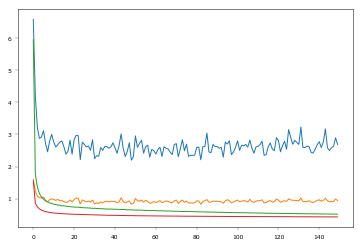

In [46]:
for k in history.history.keys():
    plt.plot(np.arange(150), history.history[k])

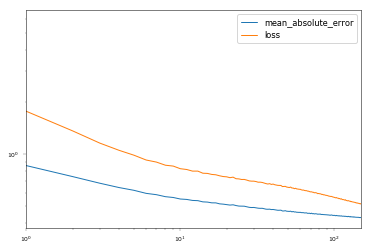

In [49]:
pd.DataFrame(history.history)[['mean_absolute_error', 'loss']].plot(logy=True, logx=True)

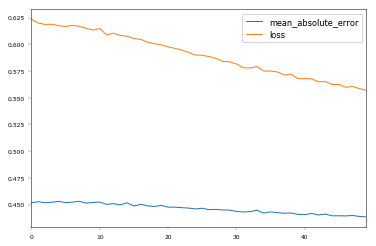

In [39]:
pd.DataFrame(history.history)[['mean_absolute_error', 'loss']].plot()

In [71]:
arparams = np.array([.5])
maparams = np.array([.25])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

In [72]:
%%time
y = np.array([sm.tsa.arima_process.arma_generate_sample(ar, ma, 167) for i in range(10000)])
y -= y.mean(axis=-1)[:,np.newaxis]
y /= y.std(axis=-1)[:,np.newaxis]

CPU times: user 409 ms, sys: 12.1 ms, total: 421 ms
Wall time: 420 ms


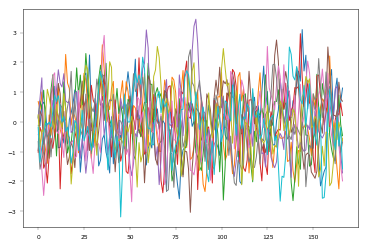

In [73]:
plt.plot(y[:10].T);

In [55]:
sm.tsa.arima_process.arma_generate_sample?

Signature: sm.tsa.arima_process.arma_generate_sample(ar, ma, nsample, sigma=1, distrvs=<built-in method randn of mtrand.RandomState object at 0x7f8610045d38>, burnin=0)
Docstring:
Generate a random sample of an ARMA process

Parameters
----------
ar : array_like, 1d
    coefficient for autoregressive lag polynomial, including zero lag
ma : array_like, 1d
    coefficient for moving-average lag polynomial, including zero lag
nsample : int
    length of simulated time series
sigma : float
    standard deviation of noise
distrvs : function, random number generator
    function that generates the random numbers, and takes sample size
    as argument
    default: np.random.randn
    TODO: change to size argument
burnin : integer (default: 0)
    to reduce the effect of initial conditions, burnin observations at the
    beginning of the sample are dropped

Returns
-------
sample : array
    sample of ARMA process given by ar, ma of length nsample

Notes
-----
As mentioned above, both the AR a